In [1]:
from itertools import product

import numpy as np
from scipy.stats import gamma, lognorm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

from epilink import (
    estimate_linkage_probability,
    estimate_linkage_probabilities,
    pairwise_linkage_probability_matrix,
    InfectiousnessParams,
    TOIT, TOST,
    presymptomatic_fraction
)
import epilink.transmission_linkage_model as model

In [2]:
plt.style.use('ggplot')
sns.set_context("paper", font_scale=1)

In [3]:
dir(model)

['Any',
 'ArrayLike',
 'InfectiousnessParams',
 'JIT',
 'TOIT',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_genetic_kernel',
 '_mean_genetic_prob_kernel',
 '_run_simulations',
 '_temporal_kernel',
 'annotations',
 'estimate_linkage_probabilities',
 'estimate_linkage_probability',
 'np',
 'npt',
 'numba',
 'pairwise_linkage_probability_matrix',
 'pd']

In [4]:
toit = TOIT()
tost = TOST()

num_simulations = 1000
no_intermediates = 11
num_samples = 1000

tost_values = np.linspace(-10, 10, num_samples)
tost_pdf = tost.pdf(tost_values)

toit_values = np.linspace(0, 20, num_samples)
toit_pdf = toit.pdf(toit_values)

genetic_distances = np.linspace(0, 15, num_samples)
delta_t_samp =  np.linspace(0, 25, num_samples)

sim_data = model._run_simulations(toit, num_simulations, no_intermediates)
temporal_prob = model._temporal_kernel(np.atleast_1d(delta_t_samp), sim_data["diff_inc"], sim_data["generation_interval"][:, 0])

sim_data_copy = sim_data.copy()
del sim_data_copy["diff_inc"]
genetic_prob = model._genetic_kernel(np.atleast_1d(genetic_distances), intermediates=no_intermediates, **sim_data_copy)

incubation = toit.sample_incubation(size=(num_samples, 2))
delta_t_exp = np.abs(delta_t_samp + (incubation[:,0] - incubation[:,1]))

In [5]:
genetic_prob.shape

(1000, 12)

In [6]:
genetic_prob[:10, :]

array([[0.274   , 0.03862 , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      , 0.      , 0.      ],
       [0.287   , 0.043517, 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      , 0.      , 0.      ],
       [0.295   , 0.04645 , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      , 0.      , 0.      ],
       [0.305   , 0.050356, 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      , 0.      , 0.      ],
       [0.314   , 0.05328 , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      , 0.      , 0.      ],
       [0.324   , 0.059116, 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      , 0.      , 0.      ],
       [0.326   , 0.06202 , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      , 0.      , 0.      ],
       [0.344   , 0.062992, 0.      , 0. 

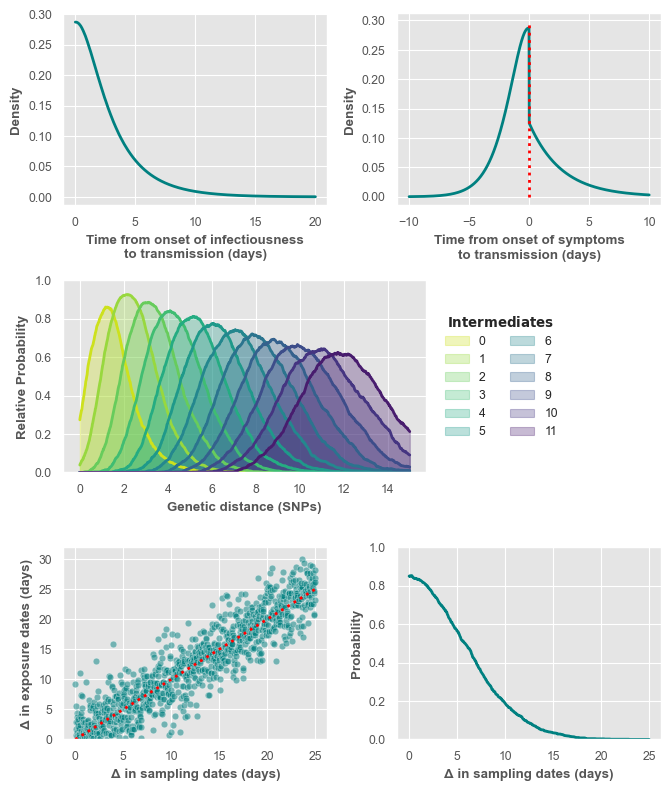

In [7]:
fig = plt.figure(figsize=(8, 8))
gs = GridSpec(3, 4, figure=fig, width_ratios=[1.7, 0.3, 0.3, 1.7])

# ---------- Row 1: two plots spanning 2 cols each ----------
ax1 = fig.add_subplot(gs[0, 0:2])   # top-left
ax2 = fig.add_subplot(gs[0, 2:4])   # top-right

sns.lineplot(x=toit_values, y=toit_pdf, color="teal", ax=ax1, linewidth=2)
ax1.set_xlabel("Time from onset of infectiousness\nto transmission (days)", fontweight="bold")
ax1.set_ylabel("Density", fontweight="bold")


sns.lineplot(x=tost_values, y=tost_pdf, color="teal", ax=ax2, linewidth=2)
ax2.set_xlabel("Time from onset of symptoms\nto transmission (days)", fontweight="bold")
ax2.set_ylabel("Density", fontweight="bold")
ax2.vlines(0, ymin=0, ymax=max(tost_pdf) + 0.01, color='red', linestyle=':', linewidth=2)

# ---------- Row 2: single plot spanning 3 cols (centered) ----------
ax3 = fig.add_subplot(gs[1, 0:3])   # spans col 0–3 (leaves col 4 blank)

palette = sns.color_palette("viridis", n_colors=genetic_prob.shape[1])[::-1]

for i in range(genetic_prob.shape[1]):
    sns.lineplot(x=genetic_distances,
                 y=genetic_prob[:, i],
                 color=palette[i], ax=ax3, linewidth=2)
    ax3.fill_between(genetic_distances,
                     genetic_prob[:, i], alpha=0.3,
                     color=palette[i], label=i)

ax3.set_xlabel("Genetic distance (SNPs)", fontweight="bold")
ax3.set_ylabel("Relative Probability", fontweight="bold")
ax3.set_ylim(0, 1)
ax3.legend(title=r"$\bf{Intermediates}$", loc="center left",
           bbox_to_anchor=(1.02, 0.5), frameon=False, ncol=2)

# ---------- Row 3: two plots spanning 2 cols each ----------
ax4 = fig.add_subplot(gs[2, 0:2])   # bottom-left
ax5 = fig.add_subplot(gs[2, 2:4])   # bottom-right

sns.scatterplot(x=delta_t_samp, y=delta_t_exp, alpha=0.5, color='teal', ax=ax4)
sns.lineplot(x=[0, 25], y=[0, 25], linestyle=":", color='red', linewidth=2, ax=ax4)
ax4.set_xlabel("Δ in sampling dates (days)", fontweight="bold")
ax4.set_ylabel("Δ in exposure dates (days)", fontweight="bold")
ax4.set_ylim(0, delta_t_exp.max() + 2)

sns.lineplot(x=delta_t_samp, y=temporal_prob, ax=ax5, color='teal', linewidth=2)
ax5.set_xlabel("Δ in sampling dates (days)", fontweight="bold")
ax5.set_ylabel("Probability", fontweight="bold")
ax5.set_ylim(0, 1)

# ---------- Finish ----------
plt.tight_layout(rect=(0, 0, 0.85, 1), w_pad=-5)
# plt.savefig(f"{figures_path}mechanistic_model_characteristics.pdf", bbox_inches="tight")
plt.show()
plt.close(fig)

Genetic distance alone cannot faithfully discriminate between different events.

In [8]:
genetic_distances = np.random.choice(list(range(30)), 100_000_000, replace=True)
temp_dists = np.random.choice(list(range(30)), 100_000_000, replace=True)

In [10]:
probability = estimate_linkage_probabilities(
    genetic_distance=genetic_distances,
    temporal_distance=temp_dists,
    intermediate_generations=(0, 1),
    num_simulations=5000
)

# Joint probability of recent transmission

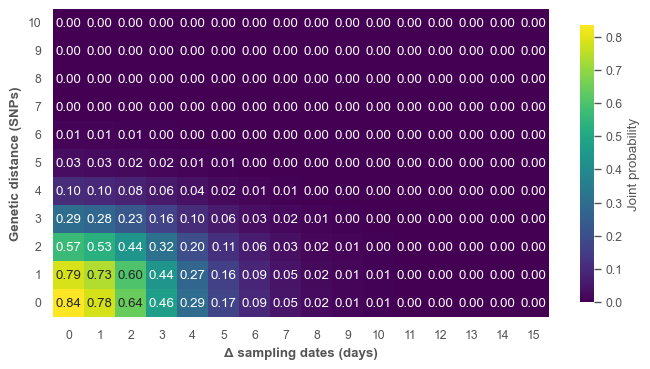

In [20]:
genetic_axis = np.arange(0, 11, 1)  # 0 to 10 SNPs
temporal_axis = np.arange(0, 31, 2) # 0 to 30 days

prob_matrix = model.pairwise_linkage_probability_matrix(
        genetic_distances=genetic_axis,
        temporal_distances=temporal_axis,
        intermediate_generations=(0, 1),
        num_simulations=5000
    )


plt.figure(figsize=(8, 4))
sns.heatmap(prob_matrix, cmap="viridis", annot=True, fmt=".2f",
            cbar_kws={"label": "Joint probability",
                      "shrink": 0.9})


plt.ylabel("Genetic distance (SNPs)", fontweight="bold")
plt.yticks(rotation=360)
plt.gca().invert_yaxis()
plt.xlabel("Δ sampling dates (days)", fontweight="bold")
# plt.savefig(f"{figures_path}pairwise_linkage_probability_matrix.pdf", bbox_inches="tight")
plt.show()
plt.close()

In [14]:
def prob_within_region(M, genetic_dist, temp_dist, max_snp, max_time):
    M = M / M.sum()
    mask = np.outer(genetic_dist <= max_snp, temp_dist <= max_time)
    return M[mask].sum()

In [15]:
prob_within_region(prop_matrix, genetic_dists, temp_dists, 3, 10)

np.float64(0.8886378244916628)

In [16]:
subs_rates = np.logspace(-4, -2, num=10)  # 20 points between 1e-4 and 1e-2
scale_incs = np.linspace(0.5, 2, num=4)

def compute_prob_within_region_params(args):
    sr, sc_inc, g, t = args  # unpack
    M = pairwise_linkage_probability_matrix(
        g, t,
        intermediate=(0, 1),
        subs_rate=sr,
        scale_inc=sc_inc
    )
    prob_w_r = prob_within_region(M, genetic_dists, temp_dists, 3, 10)
    return sr, sc_inc, prob_w_r

work = [[rate, scale, genetic_dists, temp_dists]
        for rate, scale in product(subs_rates, scale_incs)]

results = sc.parallelize(compute_prob_within_region_params, work, ncpus=2, progress=True)

cum_prob_region = pd.DataFrame(results, columns=["subs_rate", "scale_inc", "prob_within_region"])


Job 40/40 (44.4 s) •••••••••••••••••••••••••••••• 100%


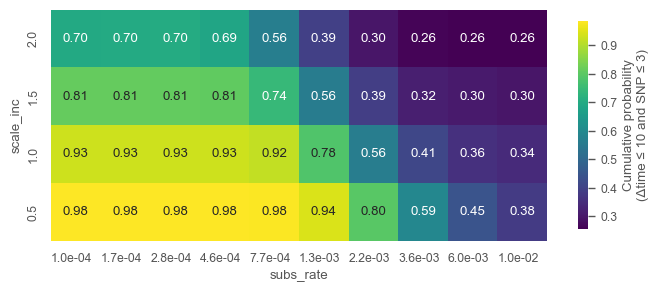

In [17]:
cum_prob_region_pivot = cum_prob_region.pivot(
    index="scale_inc", columns="subs_rate", values="prob_within_region"
)

plt.figure(figsize=(8, 3))
sns.heatmap(cum_prob_region_pivot, annot=True, cmap="viridis", fmt=".2f",
            cbar_kws={"label": "Cumulative probability\n(Δtime ≤ 10 and SNP ≤ 3)",
                      "shrink": 0.9})
plt.xticks(range(len(cum_prob_region_pivot.columns)), [f"{c:.1e}" for c in cum_prob_region_pivot.columns])
plt.xticks(rotation=0, ha="left")
plt.gca().invert_yaxis()
plt.show()

# [Sampling Delay](https://doi.org/10.3390/jcm11123269)

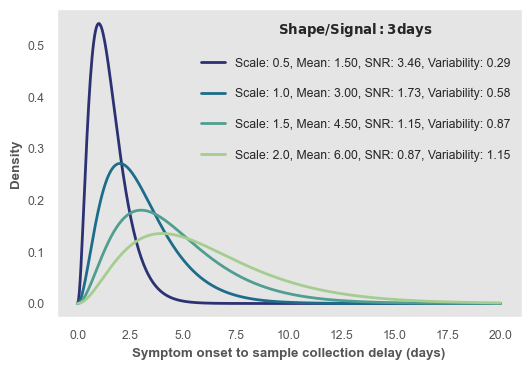

In [18]:
samp_delay = np.linspace(0, 20, 500)
plt.figure(figsize=(6, 4))
palette = [plt.get_cmap("crest_r", 4)(i) for i in range(4)]
for i, theta in enumerate([0.5, 1.0, 1.5, 2.0]):
    dist = gamma(a=3, scale=theta)
    samp_delay_prob = dist.pdf(samp_delay)
    snr = 3 / dist.std()
    variability = 1 / snr

    label = f"Scale: {theta}, Mean: {dist.mean():.2f}, SNR: {snr:.2f}, Variability: {variability:.2f}"
    plt.plot(samp_delay, samp_delay_prob, label=label, linewidth=2, color=palette[i])

plt.xlabel("Symptom onset to sample collection delay (days)", fontweight="bold")
plt.ylabel("Density", fontweight="bold")
plt.grid(False)
plt.legend(frameon=False, title=r"$\bf{Shape/Signal: 3 days}$", loc="upper right", labelspacing=1.5)
plt.savefig(f"{figures_path}sampling_delay.pdf", bbox_inches="tight")
plt.show()
plt.close()

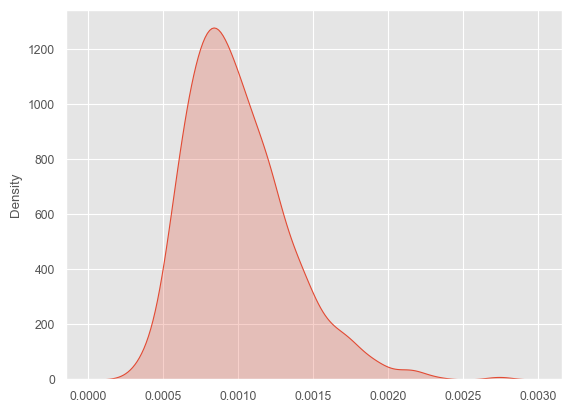

In [23]:
sigma = 0.33
mean_rate = 1e-3
mu = np.log(mean_rate) - 0.5 * sigma**2
scale = np.exp(mu)

# Create a frozen lognormal distribution
rv = lognorm(s=sigma, scale=scale)
rates = rv.rvs(1000)

sns.kdeplot(rates, fill=True);

In [24]:
# Optional: exact probability intervals
print("Central 68% interval:", rv.interval(0.68))
print("Central 95% interval:", rv.interval(0.95))

Central 68% interval: (np.float64(0.000682071286146727), np.float64(0.0013148480418964058))
Central 95% interval: (np.float64(0.000495970854586399), np.float64(0.001808211282438491))


Scale: 0.5, Mean: 2.90, SD: 1.20
Scale: 0.948, Mean: 5.51, SD: 2.28
Scale: 1.0, Mean: 5.81, SD: 2.41
Scale: 1.5, Mean: 8.71, SD: 3.61
Scale: 2.0, Mean: 11.61, SD: 4.82


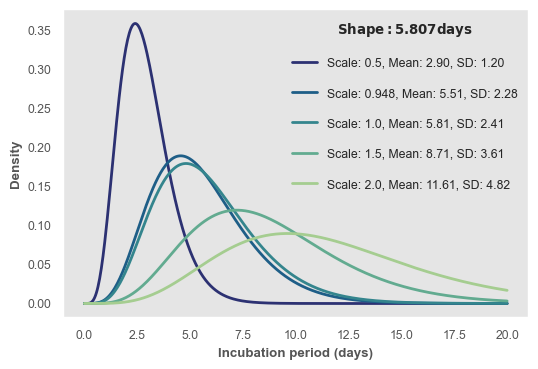

In [8]:
samp_delay = np.linspace(0, 20, 500)
plt.figure(figsize=(6, 4))
palette = [plt.get_cmap("crest_r", 5)(i) for i in range(5)]
for i, theta in enumerate([0.5, 0.948, 1.0, 1.5, 2.0]):
    dist = gamma(a=5.807, scale=theta)
    samp_delay_prob = dist.pdf(samp_delay)
    label = f"Scale: {theta}, Mean: {dist.mean():.2f}, SD: {dist.std():.2f}"
    print(label)
    plt.plot(samp_delay, samp_delay_prob, label=label, linewidth=2, color=palette[i])

plt.xlabel("Incubation period (days)", fontweight="bold")
plt.ylabel("Density", fontweight="bold")
plt.grid(False)
plt.legend(frameon=False, title=r"$\bf{Shape: 5.807 days}$", loc="upper right", labelspacing=1.5)
plt.show()
plt.close()